# Project 5: Classifying Point Clouds with PointNet

For this project, we are going to build deep learning architectures to classify point clouds that were extracted from self-driving car LiDAR scans.

Basic learning objectives of this project:
* Construct the basic pipeline used for point cloud classification
* Analyze the results from our model and look for potential points of improvement
* Understand the limitations of the model and improve it using positional encodings

## Setup

In [1]:
import sys
sys.path.insert(0, 'src')

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import torch
from vision.utils import verify

In [3]:
device = torch.device('cpu')
# If you have an NVIDIA GPU with at least 2 GB of VRAM, set this to True
use_cuda = False
# If you have an Apple Silicon Mac, set this to True
use_apple_silicon = False
if torch.cuda.is_available():
    if use_cuda:
        device = torch.device('cuda')
        print("CUDA-compatible NVIDIA GPU enabled.")
    else:
        print("CUDA-compatible NVIDIA GPU detected. Consider setting use_cuda to True.")
if torch.backends.mps.is_available() and torch.backends.mps.is_built():
    if use_apple_silicon:
        device = torch.device('mps')
        print("Apple Silicon GPU enabled.")
    else:
        print("Apple Silicon GPU detected. Consider setting use_apple_silicon to True.")
        

print("Using device: %s" % str(device))

Using device: cpu


Lets take a second to visualize a few point clouds that we are going to train our model on. You might need to rotate the visualization before you can actually see the object being represented by the points. See if you can make out this pedestrian's arms, legs, and head.

In [4]:
from vision.utils import plot_cloud_from_file

plot_cloud_from_file('data/sweeps/PEDESTRIAN/11.txt')

## Part 1: Data Loading

The first order of business we're going to take care of is writing a PyTorch dataset that will load in the data we'll be using to train and test our model. We have a total of 20 different classes that all found under the `data/sweeps` folder and each class has been split into a training and testing set. We will write a class that will load the appropriate data given the split we pass in (i.e. train/test split).

**TODO 1:** complete `part1_dataloader.py`

In [5]:
from vision.part1_dataloader import Argoverse
from torch.utils.data import DataLoader
from tests.test_part1 import (
    test_dataset_length, 
    test_unique_values, 
    test_get_points_from_file, 
    test_pad_points, 
    test_class_values
)

In [6]:
print("test_dataset_length(): ", verify(test_dataset_length))
print("test_unique_values(): ", verify(test_unique_values))
print("test_get_points_from_file(): ", verify(test_get_points_from_file))
print("test_pad_points(): ", verify(test_pad_points))
print("test_class_values(): ", verify(test_class_values))

test_dataset_length():  "Correct"
test_unique_values():  "Correct"
test_get_points_from_file():  "Correct"
test_pad_points():  "Correct"
test_class_values():  "Correct"


Now we can load in our data. When extracting object point clouds from LiDAR scans, we pruned point clouds with large numbers of points to reduce the computational demand of training and testing our classifiers. We pruned all point clouds to have a maximum of 200 points so that is the size that we will be padding all of the other point clouds to. (Feel free to adjust the batch size if you find a value that works better with your implementation)

In [6]:
train_dataset = Argoverse('train', 'data/sweeps', 200)
test_dataset = Argoverse('test', 'data/sweeps', 200)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=True)

## Part 2: Baseline

A very simple baseline to start with is a voxel-based approach. Our overall point cloud falls in a 4x4x4 meter volume in space. We can divide this up into 1x1x1 meter volumes which would give us a total of 64 $1m^3$ cells. We build a 64-dimensional feature for a point by simply counting how many points in the point cloud fall into each cell then normalizng the resulting feature vector.

For more details see the project pdf.

**TODO 2:** complete `part2_baseline.py`

In [9]:
from vision.part2_baseline import Baseline
from torch import optim
from vision.training import train, test
from tests.test_part2 import (
    test_count_points,
    test_baseline
)

In [9]:
print("test_count_points(): ", verify(test_count_points))
print("test_baseline(): ", verify(test_baseline))

test_count_points():  "Correct"
test_baseline():  "Correct"


Lets train our baseline implementation and see how it does! Fill in the hyperparameters and train your model. 

To get full credit for this section, you will need *$\geq$ 30%* accuracy on the test data set. The TAs were able to consistently achieve this accuracy with ~15 epochs.

*Hint: Play around with different voxel resolutions and the two different modes you implemented to see which configuration works the best.*

In [10]:
lr = 0.05
weight_decay = 1e-4
epochs = 15

model = Baseline(20, voxel_resolution=8, mode="count")
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

In [11]:
train_acc, train_loss, test_acc, test_loss = train(model, optimizer, epochs, train_loader, test_loader)

Epoch 1

Training...


100%|██████████| 213/213 [00:04<00:00, 49.47it/s]



Testing...


100%|██████████| 38/38 [00:00<00:00, 66.86it/s]
/Users/aurynyamamura/Documents/Computer Vision Projects/project-5-student/src/vision/training.py:94: UserWarning:

Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at /Users/runner/miniforge3/conda-bld/libtorch_1760285666619/work/torch/csrc/autograd/generated/python_variable_methods.cpp:836.)




Epoch 1 Stats:
	Training accuracy: 0.2926
	Training loss: 2.3485
	Validation accuracy: 0.2383
	Validation loss: 2.2842

Validation accuracy improved from 0 to 0.2383333295583725
Saving model to Baseline.pt


Epoch 2

Training...


100%|██████████| 213/213 [00:02<00:00, 85.65it/s] 



Testing...


100%|██████████| 38/38 [00:00<00:00, 121.67it/s]



Epoch 2 Stats:
	Training accuracy: 0.3421
	Training loss: 2.0751
	Validation accuracy: 0.2683
	Validation loss: 2.2606

Validation accuracy improved from 0.2383333295583725 to 0.2683333456516266
Saving model to Baseline.pt


Epoch 3

Training...


100%|██████████| 213/213 [00:02<00:00, 87.36it/s]



Testing...


100%|██████████| 38/38 [00:00<00:00, 99.11it/s] 



Epoch 3 Stats:
	Training accuracy: 0.3547
	Training loss: 2.0330
	Validation accuracy: 0.2517
	Validation loss: 2.2202


Epoch 4

Training...


100%|██████████| 213/213 [00:02<00:00, 91.15it/s] 



Testing...


100%|██████████| 38/38 [00:00<00:00, 99.64it/s] 



Epoch 4 Stats:
	Training accuracy: 0.3615
	Training loss: 2.0120
	Validation accuracy: 0.2617
	Validation loss: 2.2285


Epoch 5

Training...


100%|██████████| 213/213 [00:01<00:00, 108.19it/s]



Testing...


100%|██████████| 38/38 [00:00<00:00, 137.51it/s]



Epoch 5 Stats:
	Training accuracy: 0.3647
	Training loss: 1.9995
	Validation accuracy: 0.2983
	Validation loss: 2.1800

Validation accuracy improved from 0.2683333456516266 to 0.2983333468437195
Saving model to Baseline.pt


Epoch 6

Training...


100%|██████████| 213/213 [00:01<00:00, 117.12it/s]



Testing...


100%|██████████| 38/38 [00:00<00:00, 140.39it/s]



Epoch 6 Stats:
	Training accuracy: 0.3674
	Training loss: 1.9934
	Validation accuracy: 0.2967
	Validation loss: 2.1957


Epoch 7

Training...


100%|██████████| 213/213 [00:01<00:00, 116.53it/s]



Testing...


100%|██████████| 38/38 [00:00<00:00, 129.84it/s]



Epoch 7 Stats:
	Training accuracy: 0.3591
	Training loss: 1.9900
	Validation accuracy: 0.2767
	Validation loss: 2.1930


Epoch 8

Training...


100%|██████████| 213/213 [00:01<00:00, 108.06it/s]



Testing...


100%|██████████| 38/38 [00:00<00:00, 109.44it/s]



Epoch 8 Stats:
	Training accuracy: 0.3544
	Training loss: 1.9840
	Validation accuracy: 0.2500
	Validation loss: 2.1912


Epoch 9

Training...


100%|██████████| 213/213 [00:01<00:00, 114.54it/s]



Testing...


100%|██████████| 38/38 [00:00<00:00, 128.32it/s]



Epoch 9 Stats:
	Training accuracy: 0.3668
	Training loss: 1.9775
	Validation accuracy: 0.2333
	Validation loss: 2.2223


Epoch 10

Training...


100%|██████████| 213/213 [00:01<00:00, 121.60it/s]



Testing...


100%|██████████| 38/38 [00:00<00:00, 137.10it/s]



Epoch 10 Stats:
	Training accuracy: 0.3682
	Training loss: 1.9770
	Validation accuracy: 0.2783
	Validation loss: 2.2175


Epoch 11

Training...


100%|██████████| 213/213 [00:01<00:00, 117.39it/s]



Testing...


100%|██████████| 38/38 [00:00<00:00, 143.79it/s]



Epoch 11 Stats:
	Training accuracy: 0.3626
	Training loss: 1.9810
	Validation accuracy: 0.2867
	Validation loss: 2.1893


Epoch 12

Training...


100%|██████████| 213/213 [00:01<00:00, 125.23it/s]



Testing...


100%|██████████| 38/38 [00:00<00:00, 140.71it/s]



Epoch 12 Stats:
	Training accuracy: 0.3671
	Training loss: 1.9796
	Validation accuracy: 0.2817
	Validation loss: 2.1724


Epoch 13

Training...


100%|██████████| 213/213 [00:01<00:00, 120.06it/s]



Testing...


100%|██████████| 38/38 [00:00<00:00, 125.81it/s]



Epoch 13 Stats:
	Training accuracy: 0.3668
	Training loss: 1.9746
	Validation accuracy: 0.2850
	Validation loss: 2.2164


Epoch 14

Training...


100%|██████████| 213/213 [00:01<00:00, 116.92it/s]



Testing...


100%|██████████| 38/38 [00:00<00:00, 137.41it/s]



Epoch 14 Stats:
	Training accuracy: 0.3697
	Training loss: 1.9787
	Validation accuracy: 0.2550
	Validation loss: 2.1931


Epoch 15

Training...


100%|██████████| 213/213 [00:01<00:00, 113.43it/s]



Testing...


100%|██████████| 38/38 [00:00<00:00, 129.91it/s]


Epoch 15 Stats:
	Training accuracy: 0.3618
	Training loss: 1.9747
	Validation accuracy: 0.3000
	Validation loss: 2.2076

Validation accuracy improved from 0.2983333468437195 to 0.30000001192092896
Saving model to Baseline.pt




In [46]:
model = torch.load('output/Baseline.pt', weights_only=False)
test_acc, test_loss = test(model, test_loader)

100%|██████████| 38/38 [00:00<00:00, 99.47it/s] 

Test accuracy: 0.3000
Test loss: 2.1972


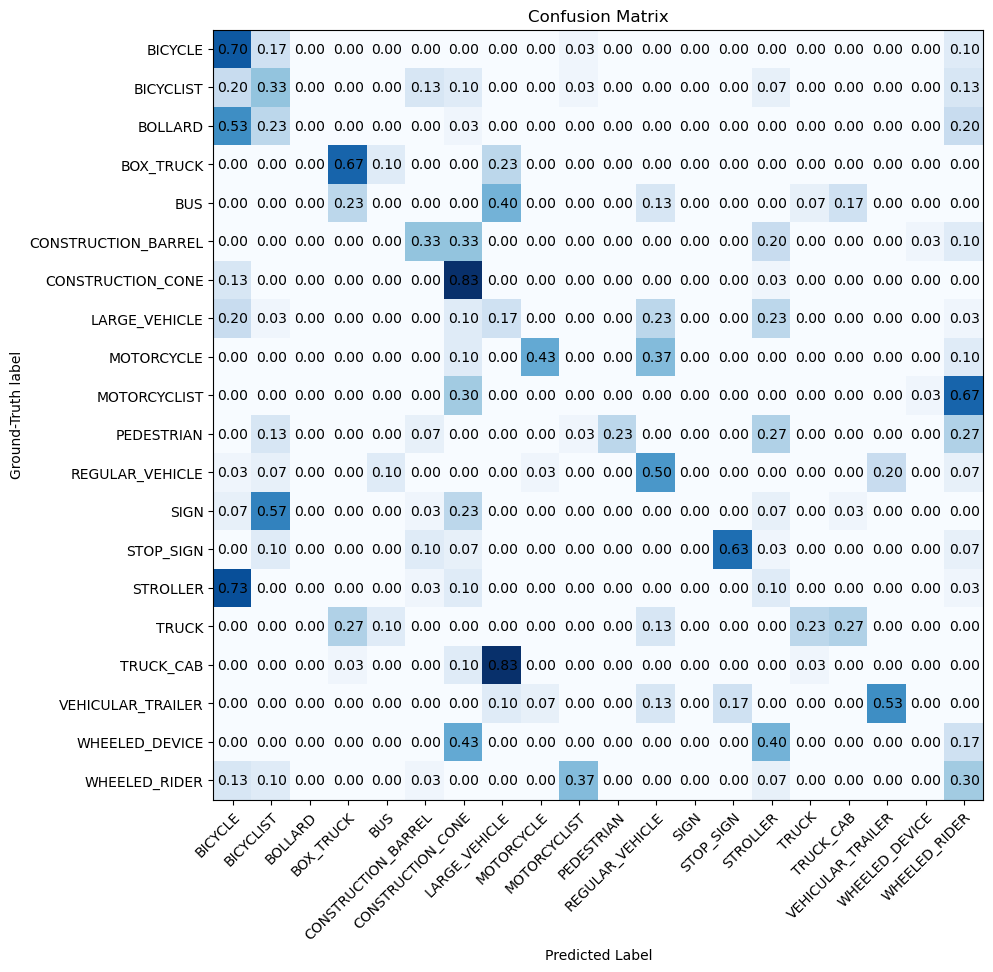

In [47]:
generate_and_plot_confusion_matrix(model, test_loader, 20)

In [48]:
plot_crit_points_from_file(model, 'data/sweeps/PEDESTRIAN/11.txt', 200)

TypeError: argmax(): argument 'input' (position 1) must be Tensor, not NoneType

## Part 3: PointNet

Now that we have a baseline to compare to, we're going to build a simplified version of PointNet which was first published in 2017 by researchers at Stanford University. You can view the original website for this publication [here](https://stanford.edu/~rqi/pointnet/). 

We will be slightly modifying the original architecture. The architecture described in the PointNet publication includes two modules that we will not be implementing. Namely, they are the input transform and the feature transform. We will also not be using our PointNet implementation for semantic segmentation so you can ignore that part of the architecture as well. For an architecture diagram of what we will be implementing, check the project pdf.

**TODO 3**: complete `part3_pointnet.py`, use the architecture diagram in the project pdf for reference.

In [7]:
from tests.test_part3 import test_pointnet
from vision.part3_pointnet import PointNet

In [14]:
print("test_pointnet(): ", verify(test_pointnet))

test_pointnet():  "Correct"


Now that we have a PointNet implementation, lets train our model and see how it does. Fill in the hyper-parameters and give your new model a spin! 

To get full credit for this section, you will need *$\geq$ 60% accuracy* on the test dataset. The TAs were able to consistently achieve this accuracy with ~15 epochs of training.

In [15]:
lr = 0.001
weight_decay = 1e-4
epochs = 10

model = PointNet(classes=20)
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

In [16]:
train_acc, train_loss, test_acc, test_loss = train(model, optimizer, epochs, train_loader, test_loader, device=device)

Epoch 1

Training...


100%|██████████| 213/213 [00:09<00:00, 22.71it/s]



Testing...


100%|██████████| 38/38 [00:00<00:00, 58.84it/s]



Epoch 1 Stats:
	Training accuracy: 0.4850
	Training loss: 1.6019
	Validation accuracy: 0.4550
	Validation loss: 1.7624

Validation accuracy improved from 0 to 0.45500001311302185
Saving model to PointNet.pt


Epoch 2

Training...


100%|██████████| 213/213 [00:09<00:00, 22.30it/s]



Testing...


100%|██████████| 38/38 [00:00<00:00, 52.02it/s]



Epoch 2 Stats:
	Training accuracy: 0.6526
	Training loss: 1.0925
	Validation accuracy: 0.4833
	Validation loss: 1.7088

Validation accuracy improved from 0.45500001311302185 to 0.4833333194255829
Saving model to PointNet.pt


Epoch 3

Training...


100%|██████████| 213/213 [00:10<00:00, 19.44it/s]



Testing...


100%|██████████| 38/38 [00:00<00:00, 53.56it/s]



Epoch 3 Stats:
	Training accuracy: 0.7400
	Training loss: 0.8207
	Validation accuracy: 0.5917
	Validation loss: 1.5184

Validation accuracy improved from 0.4833333194255829 to 0.5916666388511658
Saving model to PointNet.pt


Epoch 4

Training...


100%|██████████| 213/213 [00:10<00:00, 21.28it/s]



Testing...


100%|██████████| 38/38 [00:01<00:00, 35.73it/s]



Epoch 4 Stats:
	Training accuracy: 0.7762
	Training loss: 0.7176
	Validation accuracy: 0.5683
	Validation loss: 1.2625


Epoch 5

Training...


100%|██████████| 213/213 [00:14<00:00, 14.71it/s]



Testing...


100%|██████████| 38/38 [00:00<00:00, 43.87it/s]



Epoch 5 Stats:
	Training accuracy: 0.8068
	Training loss: 0.6261
	Validation accuracy: 0.5767
	Validation loss: 1.7102


Epoch 6

Training...


100%|██████████| 213/213 [00:08<00:00, 24.06it/s]



Testing...


100%|██████████| 38/38 [00:00<00:00, 59.10it/s]



Epoch 6 Stats:
	Training accuracy: 0.8191
	Training loss: 0.5870
	Validation accuracy: 0.5917
	Validation loss: 1.7953


Epoch 7

Training...


100%|██████████| 213/213 [00:09<00:00, 21.89it/s]



Testing...


100%|██████████| 38/38 [00:00<00:00, 48.78it/s]



Epoch 7 Stats:
	Training accuracy: 0.8376
	Training loss: 0.5197
	Validation accuracy: 0.6350
	Validation loss: 1.3503

Validation accuracy improved from 0.5916666388511658 to 0.6349999904632568
Saving model to PointNet.pt


Epoch 8

Training...


100%|██████████| 213/213 [00:09<00:00, 21.55it/s]



Testing...


100%|██████████| 38/38 [00:00<00:00, 46.98it/s]



Epoch 8 Stats:
	Training accuracy: 0.8600
	Training loss: 0.4685
	Validation accuracy: 0.5733
	Validation loss: 1.7546


Epoch 9

Training...


100%|██████████| 213/213 [00:09<00:00, 23.40it/s]



Testing...


100%|██████████| 38/38 [00:00<00:00, 48.83it/s]



Epoch 9 Stats:
	Training accuracy: 0.8485
	Training loss: 0.4914
	Validation accuracy: 0.6267
	Validation loss: 1.6446


Epoch 10

Training...


100%|██████████| 213/213 [00:08<00:00, 25.05it/s]



Testing...


100%|██████████| 38/38 [00:00<00:00, 48.56it/s]



Epoch 10 Stats:
	Training accuracy: 0.8703
	Training loss: 0.4057
	Validation accuracy: 0.5667
	Validation loss: 1.9732




In [10]:
model = torch.load('output/PointNet.pt', weights_only=False)
test_acc, test_loss = test(model, test_loader)

100%|██████████| 38/38 [00:01<00:00, 32.81it/s]

Test accuracy: 0.6350
Test loss: 1.3601


## Part 4: Performance Analysis

Now that we have a trained PointNet model, we can look at how it performs and what its shortcomings are. We are also going to analyze our point clouds to see which parts of them the model deemed to be most important in making its classification decision.

**TODO 4:** complete `part4_analysis.py`

In [12]:
from vision.utils import (
    generate_and_plot_confusion_matrix,
    plot_crit_points_from_file
)
from tests.test_part4 import (
    test_critical_indices,
    test_critical_indices_with_duplicates,
    test_confusion_matrix,
    test_confusion_matrix_normalized
)

In [19]:
print("test_critical_indices(): ", verify(test_critical_indices))
print("test_critical_indices_with_duplicates(): ", verify(test_critical_indices_with_duplicates))
print("test_confusion_matrix(): ", verify(test_confusion_matrix))
print("test_confusion_matrix_normalized(): ", verify(test_confusion_matrix_normalized))

test_critical_indices():  "Correct"
test_critical_indices_with_duplicates():  "Correct"
test_confusion_matrix():  "Correct"
test_confusion_matrix_normalized():  "Correct"


Lets use the confusion matrix to look at which mistakes our model is making most often.

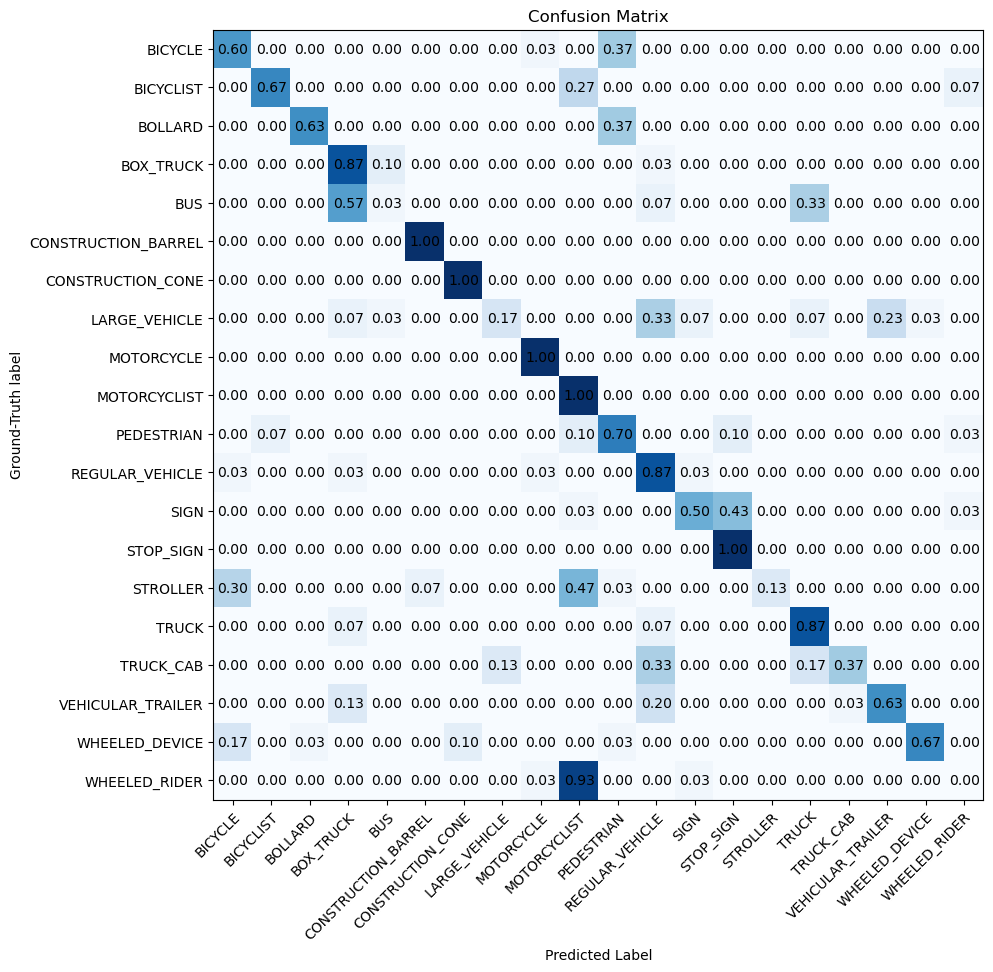

In [51]:
generate_and_plot_confusion_matrix(model, test_loader, 20)

Now lets visualize the critical points calculated by our model for the predestrian clouds from before. Recall that these are the points that contributed to the global feature. Why do you think these were the critical points the model ended up using? (Feel free to use different point clouds for your analysis)

In [63]:
plot_crit_points_from_file(model, 'data/sweeps/PEDESTRIAN/55.txt', 200)

test: torch.Size([200, 3]), torch.Size([97])


In [30]:
plot_crit_points_from_file(model, 'data/sweeps/WHEELED_RIDER/175.txt', 200)

test: torch.Size([200, 3]), torch.Size([87])


## Part 5: T-Net (Extra Credit)

Our basic PointNet model does pretty well. But let's see if we can do any better. One proposed solution to improve on the shortcomings of the basic PointNet model is using a T-Net (see pdf for more details). 

**TODO 5:** complete `part5_tnet.py`

In [39]:
from vision.part5_tnet import PointNetTNet
from tests.test_part5 import (
    test_tnet_shapes,
    test_pointnet_tnet
)

In [40]:
print("test_tnet_shapes(): ", verify(test_tnet_shapes))
print("test_pointnet_tnet(): ", verify(test_pointnet_tnet))

test_tnet_shapes():  "Correct"
test_pointnet_tnet():  "Correct"


Let's check out how our model performs now that we added a T-Net.

To get full credit for this section, you will need *$\geq$ 65% accuracy* on the test dataset. The TAs were able to achieve this accuracy with ~15 epochs of training. 

*Hint 1: You may need to play around with the number of layers in the T-Net*

*Hint 2: T-Net is sensitive to the initialization so you should try training the same model more than once*

In [41]:
lr = 0.002
weight_decay = 1e-4
epochs = 15

model = PointNetTNet(classes=20)
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

In [42]:
train_acc, train_loss, test_acc, test_loss = train(model, optimizer, epochs, train_loader, test_loader, device=device)

Epoch 1

Training...


100%|██████████| 213/213 [00:19<00:00, 11.04it/s]



Testing...


100%|██████████| 38/38 [00:01<00:00, 23.01it/s]



Epoch 1 Stats:
	Training accuracy: 0.1900
	Training loss: 2.4295
	Validation accuracy: 0.2800
	Validation loss: 2.3234

Validation accuracy improved from 0 to 0.2800000011920929
Saving model to PointNetTNet.pt


Epoch 2

Training...


100%|██████████| 213/213 [00:19<00:00, 10.84it/s]



Testing...


100%|██████████| 38/38 [00:01<00:00, 29.96it/s]



Epoch 2 Stats:
	Training accuracy: 0.3971
	Training loss: 1.7864
	Validation accuracy: 0.3983
	Validation loss: 1.7667

Validation accuracy improved from 0.2800000011920929 to 0.398333340883255
Saving model to PointNetTNet.pt


Epoch 3

Training...


100%|██████████| 213/213 [00:17<00:00, 11.97it/s]



Testing...


100%|██████████| 38/38 [00:01<00:00, 21.37it/s]



Epoch 3 Stats:
	Training accuracy: 0.4926
	Training loss: 1.4958
	Validation accuracy: 0.3500
	Validation loss: 1.9345


Epoch 4

Training...


100%|██████████| 213/213 [00:35<00:00,  6.00it/s]



Testing...


100%|██████████| 38/38 [00:01<00:00, 36.32it/s]



Epoch 4 Stats:
	Training accuracy: 0.5762
	Training loss: 1.3066
	Validation accuracy: 0.3883
	Validation loss: 1.7281


Epoch 5

Training...


100%|██████████| 213/213 [00:22<00:00,  9.45it/s]



Testing...


100%|██████████| 38/38 [00:01<00:00, 23.63it/s]



Epoch 5 Stats:
	Training accuracy: 0.6262
	Training loss: 1.1365
	Validation accuracy: 0.4400
	Validation loss: 1.9058

Validation accuracy improved from 0.398333340883255 to 0.4399999976158142
Saving model to PointNetTNet.pt


Epoch 6

Training...


100%|██████████| 213/213 [00:20<00:00, 10.52it/s]



Testing...


100%|██████████| 38/38 [00:01<00:00, 26.63it/s]



Epoch 6 Stats:
	Training accuracy: 0.6650
	Training loss: 1.0764
	Validation accuracy: 0.4883
	Validation loss: 1.6517

Validation accuracy improved from 0.4399999976158142 to 0.4883333444595337
Saving model to PointNetTNet.pt


Epoch 7

Training...


100%|██████████| 213/213 [00:20<00:00, 10.17it/s]



Testing...


100%|██████████| 38/38 [00:01<00:00, 26.94it/s]



Epoch 7 Stats:
	Training accuracy: 0.6874
	Training loss: 0.9888
	Validation accuracy: 0.4000
	Validation loss: 1.9935


Epoch 8

Training...


100%|██████████| 213/213 [00:23<00:00,  9.01it/s]



Testing...


100%|██████████| 38/38 [00:01<00:00, 19.38it/s]



Epoch 8 Stats:
	Training accuracy: 0.7403
	Training loss: 0.8361
	Validation accuracy: 0.5583
	Validation loss: 1.4759

Validation accuracy improved from 0.4883333444595337 to 0.5583333373069763
Saving model to PointNetTNet.pt


Epoch 9

Training...


100%|██████████| 213/213 [00:27<00:00,  7.81it/s]



Testing...


100%|██████████| 38/38 [00:01<00:00, 23.44it/s]



Epoch 9 Stats:
	Training accuracy: 0.7565
	Training loss: 0.7728
	Validation accuracy: 0.5500
	Validation loss: 1.4317


Epoch 10

Training...


100%|██████████| 213/213 [00:23<00:00,  9.08it/s]



Testing...


100%|██████████| 38/38 [00:01<00:00, 23.31it/s]



Epoch 10 Stats:
	Training accuracy: 0.7762
	Training loss: 0.7102
	Validation accuracy: 0.5133
	Validation loss: 2.0080


Epoch 11

Training...


100%|██████████| 213/213 [00:16<00:00, 12.55it/s]



Testing...


100%|██████████| 38/38 [00:00<00:00, 40.62it/s]



Epoch 11 Stats:
	Training accuracy: 0.7429
	Training loss: 0.8616
	Validation accuracy: 0.5167
	Validation loss: 1.5978


Epoch 12

Training...


100%|██████████| 213/213 [00:17<00:00, 12.05it/s]



Testing...


100%|██████████| 38/38 [00:01<00:00, 23.90it/s]



Epoch 12 Stats:
	Training accuracy: 0.7947
	Training loss: 0.6429
	Validation accuracy: 0.5800
	Validation loss: 1.6092

Validation accuracy improved from 0.5583333373069763 to 0.5799999833106995
Saving model to PointNetTNet.pt


Epoch 13

Training...


100%|██████████| 213/213 [00:21<00:00,  9.73it/s]



Testing...


100%|██████████| 38/38 [00:01<00:00, 30.75it/s]



Epoch 13 Stats:
	Training accuracy: 0.8047
	Training loss: 0.6137
	Validation accuracy: 0.5783
	Validation loss: 1.5048


Epoch 14

Training...


100%|██████████| 213/213 [00:23<00:00,  8.88it/s]



Testing...


100%|██████████| 38/38 [00:01<00:00, 23.85it/s]



Epoch 14 Stats:
	Training accuracy: 0.8235
	Training loss: 0.6013
	Validation accuracy: 0.5667
	Validation loss: 1.5394


Epoch 15

Training...


100%|██████████| 213/213 [00:21<00:00, 10.00it/s]



Testing...


100%|██████████| 38/38 [00:01<00:00, 25.52it/s]



Epoch 15 Stats:
	Training accuracy: 0.8106
	Training loss: 0.6092
	Validation accuracy: 0.6733
	Validation loss: 1.1192

Validation accuracy improved from 0.5799999833106995 to 0.6733333468437195
Saving model to PointNetTNet.pt




In [49]:
model = torch.load('output/PointNetTNet.pt', weights_only=False)
test_acc, test_loss = test(model, test_loader)

100%|██████████| 38/38 [00:02<00:00, 17.50it/s]

Test accuracy: 0.6733
Test loss: 1.1161


Lets take a look at how the addition of positional encoding improved on the performance of our original PointNet model. Which classes does the positional encoding help the most with? Which ones does it not really seem to make much of a difference for? Why?

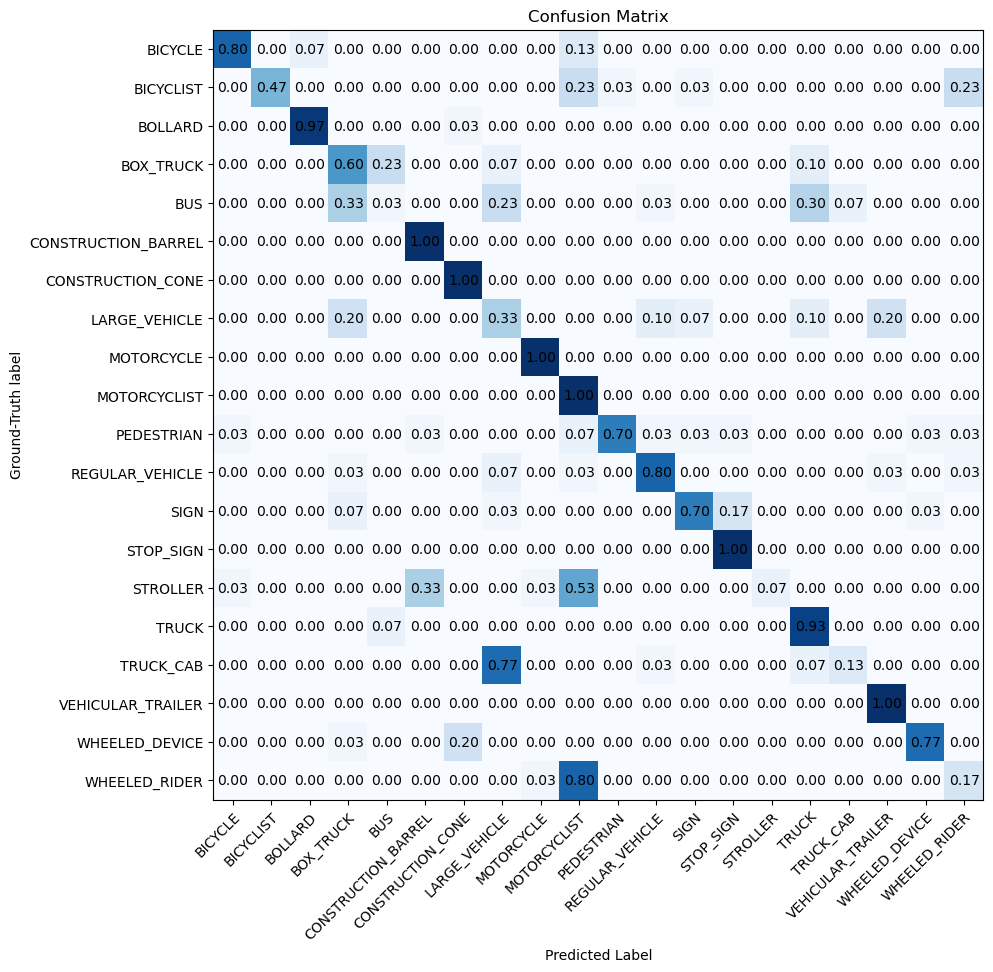

In [44]:
generate_and_plot_confusion_matrix(model, test_loader, 20)

In [45]:
plot_crit_points_from_file(model, 'data/sweeps/PEDESTRIAN/11.txt', 200)

test: torch.Size([200, 3]), torch.Size([110])
